In [12]:
%cd "C:/app"

C:\app


In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')


sns.set(rc={'figure.figsize':(10,5)})
sns.set_theme()
sns.set_style('whitegrid')

In [14]:
# load data
from sklearn.preprocessing import scale

data = pd.read_csv("./data/trees/features_targets.csv", index_col="Timestamp", parse_dates=["Timestamp"])


excluded_cols = ['Open',
 'High',
 'Low',
 'Close',
 'Symbol']

all_cols = [c for c in data.columns if c not in excluded_cols ]
data = data[all_cols]

data.loc[:, data.columns] = scale(data)

features_cols = data.columns[data.columns.str.contains("TARGET") == False]
features = data[features_cols]
features.describe()

target_col = "TARGET_LOGRET_5"
targets = data[[target_col]]
targets.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13906 entries, 2018-01-26 15:00:00 to 2019-12-31 15:30:00
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   TARGET_LOGRET_5  13906 non-null  float64
dtypes: float64(1)
memory usage: 217.3 KB


In [15]:
X = features
y_binary = (targets>0).astype(int)
y_binary.value_counts()

TARGET_LOGRET_5
1                  7207
0                  6699
Name: count, dtype: int64

<Axes: ylabel='Density'>

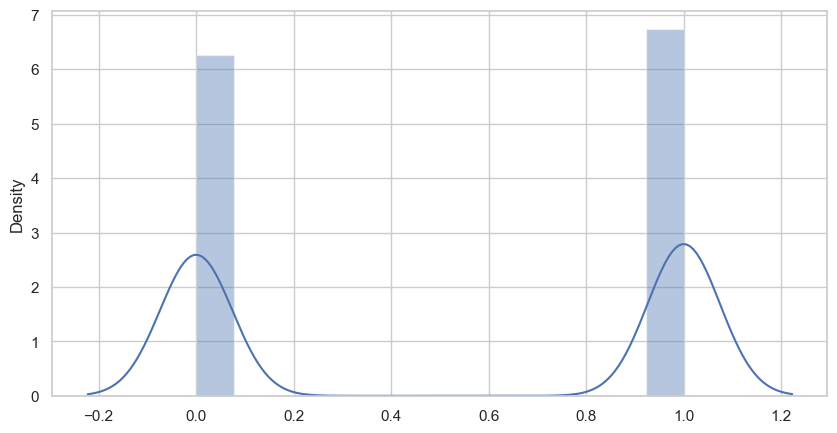

In [16]:
# Explore data
sns.distplot(y_binary)

**Overfitting, Regularization & Parameter Tuning**

In [17]:
# Cross-validation parameters
from sklearn.model_selection import TimeSeriesSplit

n_splits = 10
train_period_length = 60
test_period_length = 6
lookahead = 1
x_train = targets.head(100)

n_samples = len(x_train)
n_splits = int((n_samples-1)/test_period_length)

cv = TimeSeriesSplit(max_train_size=train_period_length, 
                     test_size=test_period_length,
                     n_splits=n_splits)
for train_idx, test_idx in cv.split(x_train):
    print("train indices")
    print(train_idx)
    print("test indices")
    print(test_idx)
    print('-' * 10)


train indices
[0 1 2 3]
test indices
[4 5 6 7 8 9]
----------
train indices
[0 1 2 3 4 5 6 7 8 9]
test indices
[10 11 12 13 14 15]
----------
train indices
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
test indices
[16 17 18 19 20 21]
----------
train indices
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
test indices
[22 23 24 25 26 27]
----------
train indices
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27]
test indices
[28 29 30 31 32 33]
----------
train indices
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33]
test indices
[34 35 36 37 38 39]
----------
train indices
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
test indices
[40 41 42 43 44 45]
----------
train indices
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39

**Hyper Parameter Selection**

In [18]:
max_depths = range(1, 16)
param_grid = {'max_depth': [2, 3, 4, 5, 6, 7, 8, 10, 12, 15],
              'min_samples_leaf': [5, 25, 50, 100],
              'max_features': ['sqrt', None]}

**Classification Tree**

In [19]:

from sklearn.model_selection import GridSearchCV

train_period_length = 500
test_period_length = 50

cv = TimeSeriesSplit(
            max_train_size=train_period_length, 
            test_size=test_period_length
        );

In [20]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=42)

# f_score: 2 * (precision * recall) / (precision + recall)

metric = "accuracy" # 'roc_auc',

# gridsearchCV: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
# metrics: https://scikit-learn.org/stable/modules/model_evaluation.html

gridsearch_clf = GridSearchCV(estimator=clf,
                          param_grid=param_grid,
                          scoring=metric, # accuracy
                          n_jobs=-1, # -1 means using all processors
                          cv=cv,
                          refit=True, # Refit an estimator using the best found parameters on the whole dataset
                          return_train_score=True, # If False, the cv_results_ attribute will not include training scores
                          error_score="raise")

gridsearch_clf.fit(X=X, y=y_binary)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=500, n_splits=5, test_size=50),
             error_score='raise',
             estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 10, 12, 15],
                         'max_features': ['sqrt', None],
                         'min_samples_leaf': [5, 25, 50, 100]},
             return_train_score=True, scoring='accuracy')

In [21]:
gridsearch_clf.best_params_
gridsearch_clf.best_score_
gridsearch_clf.best_estimator_
gridsearch_clf.cv_results_

{'mean_fit_time': array([0.00894594, 0.00831895, 0.01395011, 0.00791149, 0.01325192,
        0.01390018, 0.01499858, 0.00786796, 0.00699091, 0.00580201,
        0.00692873, 0.0007647 , 0.01625872, 0.00726871, 0.00233059,
        0.01295357, 0.01102524, 0.00412397, 0.00287118, 0.00397968,
        0.00264201, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.02486758, 0.02227373, 0.        , 0.02010002,
        0.00096464, 0.        , 0.00040684, 0.        , 0.0168757 ,
        0.0069778 , 0.0168757 , 0.00271125, 0.        , 0.        ,
        0.        , 0.        , 0.0168757 , 0.03509545, 0.00304961,
        0.02155085, 0.        , 0.        , 0.00335636, 0.        ,
        0.0247076 , 0.01396346, 0.01253939, 0.00176187, 0.01253939,
        0.01609182, 0.01466732, 0.00508995, 0.03431158, 0.01636844,
        0.01804428, 0.00660367,

**Learning Curves for best models**

In [22]:
from sklearn.model_selection import learning_curve

# Classifier
sizes = np.arange(.1, 1.01, .1)

train_sizes, train_scores, valid_scores = learning_curve(gridsearch_clf.best_estimator_,
                                                         X,
                                                         y_binary,
                                                         train_sizes=sizes,
                                                         cv=cv,
                                                         scoring=metric,
                                                         n_jobs=-1,
                                                         shuffle=True,
                                                         random_state=42)

for train_size, train_score, valid_score in zip(
     train_sizes, train_scores, valid_scores
):
    print(f"{train_size} samples were used to train the model")
    print(f"The average train accuracy is {train_scores.mean():.2f}")
    print(f"The average test (validation) accuracy is {valid_scores.mean():.2f}")

clf_lc_data = pd.concat([
    pd.melt(pd.DataFrame(train_scores.T, columns=train_sizes),
            var_name='Train Size',
            value_name=metric).assign(Data='Train'),
    pd.melt(pd.DataFrame(valid_scores.T, columns=train_sizes),
            var_name='Train Size',
            value_name=metric).assign(Data='Valid')])
clf_lc_data.info()



50 samples were used to train the model
The average train accuracy is 0.70
The average test (validation) accuracy is 0.47
100 samples were used to train the model
The average train accuracy is 0.70
The average test (validation) accuracy is 0.47
150 samples were used to train the model
The average train accuracy is 0.70
The average test (validation) accuracy is 0.47
200 samples were used to train the model
The average train accuracy is 0.70
The average test (validation) accuracy is 0.47
250 samples were used to train the model
The average train accuracy is 0.70
The average test (validation) accuracy is 0.47
300 samples were used to train the model
The average train accuracy is 0.70
The average test (validation) accuracy is 0.47
350 samples were used to train the model
The average train accuracy is 0.70
The average test (validation) accuracy is 0.47
400 samples were used to train the model
The average train accuracy is 0.70
The average test (validation) accuracy is 0.47
450 samples were 

<Axes: xlabel='Train Size', ylabel='accuracy'>

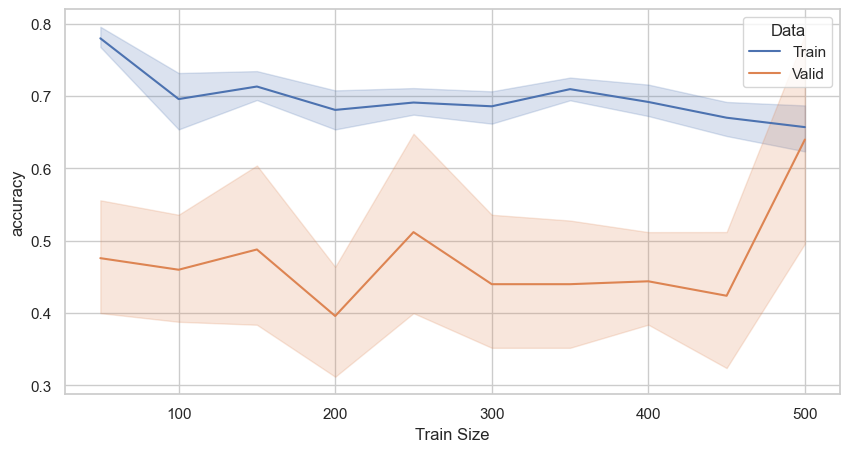

In [23]:
# check if more train data, then scores gets better for train and worse by validation
sns.lineplot(x="Train Size", y=metric, hue="Data" ,data=clf_lc_data)